# Bandpass Filtering In Audio Front End (AFE) Of Xylo™Audio 3

 The key feature extraction module in Xylo™Audio 3 is the collectuion of Mel-filterbanks, which compute the time-frequency transform of the input audio signal. In this tutorial we will review main features of the filterbank and provide instructions to reconfigure them if needed. 

Central frequency and all parameters of the filterbank have been designed for efficient audio processing, convering the range of $100~Hz$ up to around $17~KHz$ audio spectrum. They also have been hard coded in AFESim3 (:py:class:`~.syns65302.AFESim`).  

  Main features of the filterbank include:

 * Logarithmically spaced, matched to human perception mechanism, with following **frequency scaling** $\alpha$ and **quality factor** $Q$:

     $ \alpha = (\frac{17000}{100})^{1/(16-1)}= 170^{\frac{1}{15}} = 1.4083$    and $~~~~~~ Q \approx 6$ 
     
 *  Implemented with order-1 Butterworth filters  with digital transfer function: $~~~~~~H(z)= \frac{b(z)}{a(z)}=\frac{b_0 + b_1 z + b_2 z^2}{a_0 + a_1 z + a_2 z^2}$.
 
 *   Implemented as a cascaded of AR (auto-regressive filter) $H_1(z)=\frac{1}{a(z)}$ followed by the MA (moving average) filter $H_2(z)=b(z)$, as illustrated in the  block diagram below

 *   **In Rockpool:**  implemented as quantized digital filterbank with hard coded parameters. (See :py:class:`~.syns65302.AFESim`). 


Default central frequencies in Xylo™Audio 3 are:

In [1]:
import numpy as np
f0 = 100
f15 = 17000
N_filters = 16 # number of filters
alpha = np.power(f15/f0, 1/(N_filters-1))
freqs = [f0]
for i in range(1,N_filters):
    freqs.append(int(alpha*freqs[-1]))
print(f'designed filter centers are: {freqs}')    

designed filter centers are: [100, 140, 197, 277, 390, 549, 773, 1088, 1532, 2157, 3037, 4277, 6023, 8482, 11945, 16822]


Let's instantiate AFESim:

In [2]:
from rockpool.devices.xylo.syns65302 import AFESimExternal
import warnings
warnings.filterwarnings('ignore')

dt_s = 0.009994
afesim_external = AFESimExternal.from_specification(spike_gen_mode="divisive_norm",
                                                    fixed_threshold_vec = None,
                                                    rate_scale_factor=63,
                                                    low_pass_averaging_window=84e-3,
                                                    dn_EPS=32,
                                                    dt=dt_s,)

Let's demonstrate the response of filters in the simulator :py:class:`~.syns65302.AFESim` by passing monotone sinusoids as input (first and fifth filters with central frequencies $100~Hz$ and $390~Hz$). 

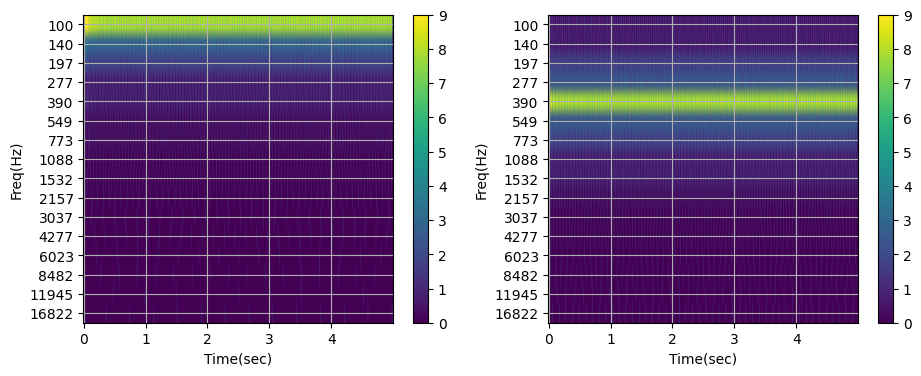

In [3]:
from rockpool.devices.xylo.syns65302.afe import ChipButterworth
import matplotlib.pyplot as plt

test_freqs = [freqs[0], freqs[4]]  #input frequency 
fs = 48000 #sampling rate 
N = 5 #input duration (seconds)
time = np.linspace(0,N,int(N*fs))

EPS = 0.00001
fb = ChipButterworth()
B_in = fb.bd_list[0].B_in + 4 # quantization range for input signal

plt.figure(figsize=(11,4))
for i,f in enumerate(test_freqs):
    sig_in = np.sin(2*np.pi*f*time)
    # quantize the sinal
    sig_in = sig_in/np.max(np.abs(sig_in)) * (1 + EPS) * 2**(B_in-1)
    q_sig_in = sig_in.astype(np.int64)
    output,_, _ = afesim_external((q_sig_in,fs))
    ax = plt.subplot(1,2,i+1)
    plt.imshow(output.T, aspect='auto'); 
    plt.grid(True); plt.xlabel('Time(sec)'); plt.ylabel('Freq(Hz)')
    ax.set_xticks(range(0,500, 100)); ax.set_yticks(range(N_filters))
    ax.set_xticklabels( [int(t * np.round(dt_s, decimals=2)) for t in ax.get_xticks()])
    ax.set_yticklabels(freqs); plt.colorbar()

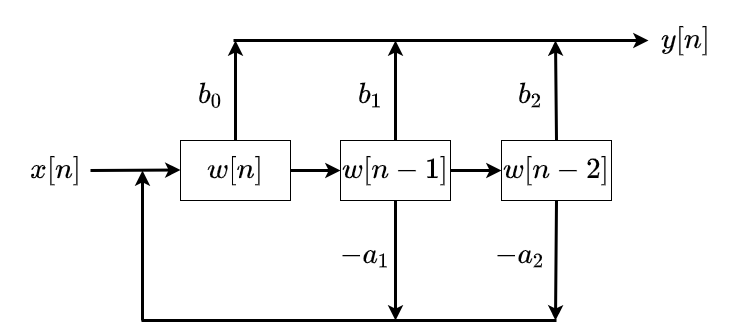

In [4]:
from IPython.display import Image
Image("figures/block_diagram.png")

### Reconfiguration of filter parameters
As mentioned above, this design value of filter parameters are suitable for efficient audio processing. They have been carefully chosen for good coverage of the the range between $100~Hz$ and $17~KHz$ and numerical stability. 

Changing these parameters is not recomeneded for audio applications. However expert users can modify filter parameters in simulator and also rerconfigure relevant registers in hardware configuration, to shift the center of filters to desired values, for special non-audio use cases .   

Main parameters to modify are $a_1$ and $a_2$ in $H(z)$ and using $scipy.signal.iirpeak()$  we can find  the parameters of the transfer function. 

Following block can be used to calculate transfer function of a desired filter  (required $a_1$ and $a_2$) parameters. 

In [5]:
import numpy as np
f0 = 300
f15 = 20000
N_filters = 16 # number of filters
alpha = np.power(f15/f0, 1/(N_filters-1))
new_freqs = [f0]
for i in range(1,N_filters):
    new_freqs.append(int(alpha*new_freqs[-1]))
print(f'designed filter centers are: {new_freqs}')  

designed filter centers are: [300, 396, 523, 691, 914, 1209, 1599, 2115, 2798, 3702, 4898, 6480, 8573, 11342, 15006, 19854]


In [6]:
from scipy import signal
Q = 6  #Qfactor
new_params = []
for f in new_freqs:
    # Get digital filter coefficients (z-domain)
    filter_params = signal.iirpeak(f, Q, fs=fs)
    new_params.append(filter_params)

b, a =   new_params [0] #parameters of the first filter
a1 , a2 = a[1], a[2]

As in :py:class:`~.syns65302.AFESim` quantized version of filters are implemented (to match Xylo™Audio 3), $a_1$ and $a_2$ parameters need to be quantized as follows:


- $$\tilde{a}_1=[2^{B_b} 2^{B_{a,f}} a_1]~~~~~~~~~\tilde{a}_2=[2^{B_b} 2^{B_{a,f}} a_2]$$
where: 
- $B_b$ : bits needed for scaling b0
- $B_{af}$ : bits needed for encoding the fractional parts of taps

Without going into details, $B_b$ and $B_{af}$ are integer values defining precision of each parameter in the filter. They have been hard coded in :py:class:`~.syns65302.AFESim` for each of 16 filters and should not be modified. 

Please note that central frequency of low-frequency filters in HDK can shift from design value due to poor dynamic range in their filter coefficients and with chosen values (around 16 bits).

While the consequence is not significant for audio processing configuration, users need to have this in mind for the use cases that require central frequcies below $100~Hz$.

$\tilde{a}_1$ and $\tilde{a}_2$ can be replaced in `~.syns65302.afe.ChipButterworth` module for each filter. 

Equavalently in HDK @karla please add the relevenat registers. 
